# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv.

Проверим наличие дубликатов в идентификаторах пользователей. Сравним размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

## Анализ времени взаимодействия с контентом приложения Яндекс.Книги пользователей из Москвы и Санкт-Петербурга

- Автор: Федотова Инна
- Дата: 30.04.2025

## Цели и задачи проекта

Цель проекта, с помощью статистических тестов проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят, в среднем, больше времени за чтением и прослушиванием книг в приложении Яндекс.Книги, чем пользователи из Москвы.
Перед проверкой нужно обработать данные, чтобы получить достоверные результаты теста.

## Описание данных

Работаем с датасетом `datasets/yandex_knigi_data.csv`, который содержит данные о чтении и прослушивании контента в сервисе Яндекс Книги. Датасет включает информацию о пользователях, длительности сессий и городах: Москва и Санкт-Петербург. Данные представлены за период с 1 сентября по 11 декабря 2024 года. 

- `puid` — идентификатор пользователя;
- `hours` — длительность чтения или прослушивания в часах;
- `city` — город.

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python
3. Аналитическая записка

---

## 1. Загрузка данных и знакомство с ними

Загружаем данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из  `/datasets/yandex_knigi_data.csv`.

In [1]:
# Выгружаем библиотеки с которыми будем работать
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Загрузим библиотеку для проведения теста Манна-Уитни
from scipy.stats import mannwhitneyu

#Загрузим библиотеки для оценки достаточности выборки для получения статистически значимых результатов A/B-теста
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

#Загрузим библиотеку для проведения Z-теста
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Создаем датафрейм с данными
ya_knigi= pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

ya_knigi.info()

ya_knigi.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


В таблице ya_knigi 8783 строк и 4 столбца. Видим, что пропусков в данных нет, осталось проверить на дубликаты.


In [3]:
#Проверяем датасет на дубликаты по идентификатору пользователя
ya_knigi.duplicated(subset=['puid']).sum()

244

In [4]:
# Удаляем дубликаты
ya_knigi=ya_knigi.drop_duplicates(subset=['puid'])
ya_knigi.info()
ya_knigi.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8540 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8540 non-null   int64  
 1   city        8540 non-null   object 
 2   puid        8540 non-null   int64  
 3   hours       8540 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 333.6+ KB


,Unnamed: 0,city,puid,hours
8778,8778,Санкт-Петербург,1130000027468068,5.879444
8780,8780,Санкт-Петербург,1130000030307246,45.069222
8781,8781,Санкт-Петербург,1130000038726322,0.211944
8782,8782,Санкт-Петербург,1130000047892100,4.311841
8783,8783,Санкт-Петербург,1130000061443598,20.847222


В процессе обработки удалили 244 дубликата по идентификатору пользователя.

In [5]:
#Для проведения теста, нам нужно убедиться, что выборки сопоставимы и независимы
#Группируем данные по городу и считаем уникальных пользователей
grp = (
    ya_knigi
    .groupby(['city'])
    .agg({
        'puid': 'nunique'
    })
    .reset_index()
)

grp.head()

,city,puid
0,Москва,6234
1,Санкт-Петербург,2306


In [6]:
#Создадим выборки для Москвы и Санкт-Петербурга
mos=ya_knigi[ya_knigi.city=='Москва']
spb=ya_knigi[ya_knigi.city=='Санкт-Петербург']
#Проверим пересечения в выборках
intersection = list(set(mos['puid']) & set(spb['puid']))
intersection

[]

Группы независимы, так как нет пользователей, которые встречаются одновременно в двух группах.

Пользователей из Москвы почти в 3 раза больше, чем пользователей из Санкт-Петербурга, это может исказить результаты теста. 

Проверим распределение по времени взаимодествия с контентом для Москвы и Санкт-Петербурга

In [7]:
#Создадим выборки с временем взаимодействия с контентом для Мск и Спб
mos_hours=mos['hours']
spb_hours=spb['hours']
#Посмотрим распределение данных о времени взаимодействия
display(mos_hours.describe(),
        spb_hours.describe())

count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

Видим, что для данных характерен большой разброс. При этом, среднее значение, стандартное отклонение, квантили, минимальные и максимальные значения достаточно сопоставимы для двух выборок.

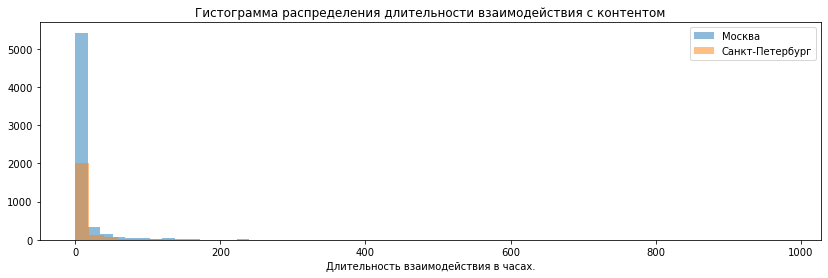

In [8]:
#Построим гистограмму рапрседеления данных для двух городов
plt.figure(figsize=(14, 4))
plt.hist(mos_hours, bins=50, label='Москва', alpha=0.5)
plt.hist(spb_hours, bins=50, label='Санкт-Петербург', alpha=0.5)

plt.xlabel('Длительность взаимодействия в часах.')
plt.title('Гистограмма распределения длительности взаимодействия с контентом')
plt.legend()
plt.show()

Распределение у выборок экспоненциональное, также в распределении имеются большие хвосты. В связи с этим, для проверки гипотезы будем использовать тест Манна-Уитни.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [9]:
# Установим уровень значимости =5%
alpha=0.05
#Применяем тест Манна-Уитни
mw_test = mannwhitneyu(
    spb_hours,
    mos_hours,
    alternative='greater' # тк по альтернативной гипотезе в Спб время взаимодействия больше чем в Мск
) 

if mw_test.pvalue >alpha:
    print(f'p-value теста Манна — Уитни ={round(mw_test.pvalue, 2)}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах не различаются')
    print('Интерпретация: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')


else:
    print(f'p-value теста Манна — Уитни ={round(mw_test.pvalue, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группе A меньше, чем в B')
    print('Интерпретация: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо')   


p-value теста Манна — Уитни =0.62
Нулевая гипотеза находит подтверждение! Распределения метрики в группах не различаются
Интерпретация: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается


## 3. Аналитическая записка
Проверяли гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

- Для проверки выбран тест Манна — Уитни и уровень статистической значимости - 5%.

- p-value=0.38, нулевая гипотеза нашла подтверждение.

- Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается. Гипотеза о том, что пользователи из Санкт-Петербурга дольше взаимодействует с контентом, чем пользователи из Москвы - отвергнута.

- Вероятно, пользователи ведут себя схожим образом из-за того что находятся в крупнейших и экономически развитых городах России.



----

# Часть 2. Анализ результатов A/B-тестирования

Теперь нам нужно проанализировать другие данные. К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Наша задача — провести оценку результатов A/B-теста. В нашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оценим корректность проведения теста и проанализируем его результаты.

## 1. Цели исследования.



Ислледование результата A/B-теста, для проверки гипотезы:
- упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе, конверсия зарегистрированных пользователей в покупателей увеличится, как минимум, на три процентных пункта.

## 2. Загружаем данные и оцениваем их целостность.


In [10]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [11]:
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


В датафрейме 4 столбца и 14524 строк, пропусков в данных нет. По данным видно, что некоторые пользователи участвуют в нескольких тестах одновременно. Для того чтобы обеспечить независимость выборок, таких пользователей нужно будет искючить.

In [12]:
#Проверим на дубликаты
participants.duplicated(subset='user_id').sum()


887

In [13]:
#Удалим дубликаты
participants=participants.drop_duplicates(subset='user_id')
participants.duplicated().sum()

0

In [14]:
#Посмотрим информацию по датафрейму с событиями
events.info()
events.tail(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


,user_id,event_dt,event_name,details
787271,GLOBAL,2020-12-31 23:56:17,purchase,4.49
787272,CA617333EFAE4A10,2020-12-31 23:56:25,login,NaN
787273,CA617333EFAE4A10,2020-12-31 23:56:25,registration,-2.85
787274,GLOBAL,2020-12-31 23:56:35,product_cart,NaN
787275,CA617333EFAE4A10,2020-12-31 23:56:43,product_page,NaN
787276,B4B38B24350CD88F,2020-12-31 23:56:46,login,NaN
787277,10CAFD77114A4537,2020-12-31 23:56:56,registration,-4.07
787278,B0058FAB9B1146C2,2020-12-31 23:57:28,product_cart,NaN
787279,CA617333EFAE4A10,2020-12-31 23:57:31,product_page,NaN
787280,10CAFD77114A4537,2020-12-31 23:57:35,product_page,NaN


- В датафрейме 4 столбца и 787285 строк. 

- В столбце details около 70% пропущенных значений, что связано с данными в этом столбце. В нем отображается стоимость привлечения зарегистрировавшихся пользователей, стоимость покупки, или код региона пользователя. Так как среди событий множество просмотров страниц с товарами, то для них нет деталей. Можно сделать вывод о том, что такое большое количество пропусков говорит об особенностях сбора данных, а не об ошибке.

- В столбце с идентификатором пользователя, неожиданно появилось значение GLOBAL. Вероятно, в исторических данных так отображались оффлайн пользователи или пользователи, которые не прошли регистрацию. 

In [15]:
#Посмотрим подробнее какие типы событий характерны для глобальных пользователей:
events_global=events.loc[events['user_id']=='GLOBAL']
events_global.groupby('event_name')['user_id'].count()

event_name
End of Black Friday Ads Campaign          1
Start of CIS New Year Gift Lottery        1
Start of Christmas&New Year Promo         1
product_cart                           9806
product_page                          33166
purchase                              15520
Name: user_id, dtype: int64

Видим, что у таких пользователей, нет событий с типом "регистрация" или "логин", но есть действия добавления в корзину, просмотра страницы товара и покупки. Скорее всего, идентификатора нет у незарегистрированных пользователей. Таких пользователей, придется исключить из анализа.

In [16]:
#Отфильруем датафрейм от незарегистрированных пользователей GLOBAL
events=events.loc[events['user_id']!='GLOBAL']


## 3. По таблице `ab_test_participants` оценим корректность проведения теста:

   3\.1 Выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [17]:
#Проверим пересечение пользователей в рамках одного теста или участвующих одновременно в двух

participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test>1')

,ab_test
user_id,


Видим, что теперь нет пользователей участвующих одновременно в двух тестах. Мы исключили таких пользователей, на этапе удаления дубликатов. 

In [18]:
#Выделим пользователей, участвующих только в интересующем нас тесте interface_eu_test
test_participants=participants.loc[participants['ab_test']=='interface_eu_test']

test_participants.info()
test_participants.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10403 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10403 non-null  object
 1   group    10403 non-null  object
 2   ab_test  10403 non-null  object
 3   device   10403 non-null  object
dtypes: object(4)
memory usage: 406.4+ KB


,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
7,0031F1B5E9FBF708,A,interface_eu_test,Android


In [19]:
#Считаем количество уникальных пользователей в каждой группе
grp_test=test_participants.groupby(['group']).agg({
        'user_id': 'nunique',
    }).reset_index()
grp_test

,group,user_id
0,A,5174
1,B,5229


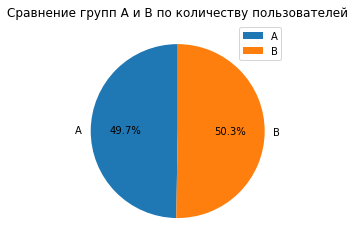

In [20]:
#Строим график для сравнения групп по количеству пользователей

plt.pie(grp_test['user_id'], labels=grp_test['group'], autopct='%1.1f%%', startangle=90)

plt.legend()
plt.title('Сравнение групп A и B по количеству пользователей')
plt.show()

In [21]:
#Посчитаем процентную разницу в количестве пользователей между группами А и В
a=grp_test.loc[(grp_test['group']=='A')]['user_id'].sum()
b=grp_test.loc[(grp_test['group']=='B')]['user_id'].sum()
print(f'{a, b}')
perc_difference=100 * abs(a-b)/b
print(f'Процентная разница между группами А и В:{perc_difference}')

(5174, 5229)
Процентная разница между группами А и В:1.0518263530311722


Процентная разница между группами составляет 1%, это говорит о том что группы сопоставимы по количеству пользователей.

In [22]:
#Проверим равномерность разделения пользователей по устройствам
#Группируем данные, чтобы получить количество уникальных пользователей для каждой комбинации группы и устройства
grp_device=test_participants.groupby(['group','device'])['user_id'].nunique().reset_index()
grp_device


,group,device,user_id
0,A,Android,2356
1,A,Mac,542
2,A,PC,1286
3,A,iPhone,990
4,B,Android,2320
5,B,Mac,527
6,B,PC,1356
7,B,iPhone,1026


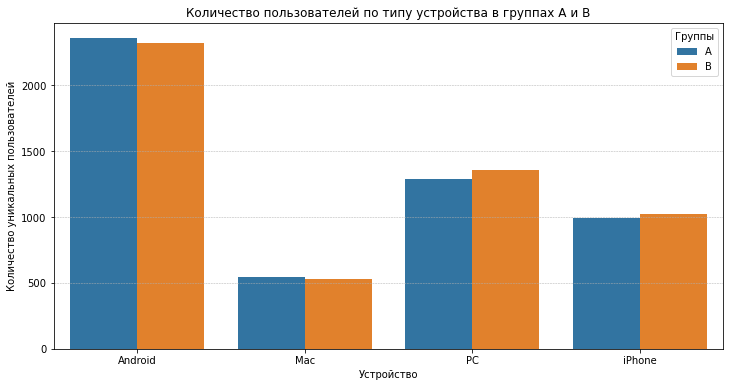

In [23]:
#Построим график распределения пользователей по девайсам

plt.figure(figsize=(12,6))

sns.barplot(x='device', y='user_id', hue='group', data=grp_device)
plt.title('Количество пользователей по типу устройства в группах A и B')
plt.xlabel('Устройство')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Группы')
plt.show()


На основе проведённого анализа A/B-теста сформулируем следующие выводы:

- Количество пользователей в группах практически одинаковое, процентная разница менее 1%.
- Выборки являются независимыми, так как нет пользователей, которые принадлежали бы обеим группам/другим тестам.
- По типу устройства, распределение пользоваетелей в контрольной и тестовой группах также достаточно равномерное.

A/B-тест проходит корректно, данные подходят, для проверки гипотез.

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставим только события, связанные с участвующими в изучаемом тесте пользователями;

In [24]:
#Объединим датасеты с пользователями и событиямио левому типу, чтобы сохранить данные о пользователях участвующих в тесте
df=test_participants.merge(events, on='user_id', how='left')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76658 entries, 0 to 76657
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     76658 non-null  object        
 1   group       76658 non-null  object        
 2   ab_test     76658 non-null  object        
 3   device      76658 non-null  object        
 4   event_dt    76658 non-null  datetime64[ns]
 5   event_name  76658 non-null  object        
 6   details     20217 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 4.7+ MB


,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


- определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации

In [25]:
df['event_dt'] = pd.to_datetime(df['event_dt'])  

#Определим дату первой активности (регистрации) для каждого пользователя
first_activity = df.groupby('user_id')['event_dt'].min().reset_index()
first_activity.rename(columns={'event_dt': 'registration_dt'}, inplace=True)

# Объединение данных с датой регистрации
df = pd.merge(df, first_activity, on='user_id', how='left')

#Расчет лайфтайма
df['lifetime'] = (df['event_dt'] - df['registration_dt']).dt.days

#Фильтруем события (оставляем только события в течение первых 7 дней)
df_filtered = df[df['lifetime'] <= 7]

# Вывод информации о результатах
print(f"Исходное количество событий: {len(df)}")
print(f"Количество событий после фильтрации (лайфтайм <= 7 дней): {len(df_filtered)}")

df_filtered.head()

Исходное количество событий: 76658
Количество событий после фильтрации (лайфтайм <= 7 дней): 68263


,user_id,group,ab_test,device,event_dt,event_name,details,registration_dt,lifetime
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [26]:
#Зафиксируем значения для расчета достаточности выборки
baseline_conversion_rate = 0.3  
mde = 0.1  
alpha = 0.05  
power = 0.8 

new_conversion_rate = baseline_conversion_rate * (1 + mde)

effect_size = proportion_effectsize(baseline_conversion_rate, new_conversion_rate)

power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1
)

total_sample_size = sample_size * 2

print(f"Минимальный размер выборки для каждой группы: {int(sample_size)}")
print(f"Общий размер выборки: {int(total_sample_size)}")

Минимальный размер выборки для каждой группы: 3761
Общий размер выборки: 7523


In [27]:
#Создадим выборку для каждой группы
a_df=df_filtered.loc[(df_filtered['group']=='A')]['user_id']
b_df=df_filtered.loc[(df_filtered['group']=='B')]['user_id']

count_a=a_df.nunique() 
count_b=b_df.nunique()

count_a, count_b

(5174, 5229)

In [28]:
if count_a >= sample_size and count_b >= sample_size:
    print("Выборка достаточна для проведения теста.")
else:
    print("Выборка недостаточна. Требуется больше пользователей.")

Выборка достаточна для проведения теста.


- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [29]:
#Отфильтруем датасет по пользователям, совершающим покупки
df_purchase=df_filtered.loc[(df_filtered['event_name']=='purchase')]

#Количество уникальных пользователей:
n_a = df_filtered.loc[(df_filtered['group']=='A')]['user_id'].nunique()
n_b = df_filtered.loc[(df_filtered['group']=='B')]['user_id'].nunique()
print(f'Количество уникальных пользователей для групп А и В:{n_a, n_b}')

#Количество уникальных пользователей совершивших покупку:
m_a = df_purchase.loc[(df_purchase['group']=='A')]['user_id'].nunique()
m_b = df_purchase.loc[(df_purchase['group']=='B')]['user_id'].nunique()
print(f'Количество уникальных пользователей совершивших покупку для групп А и В:{m_a, m_b}')

p_a, p_b = m_a/n_a, m_b/n_b
print(f'Доля пользователей совершающих покупки для групп А и В:{p_a:.2f}, {p_b:.2f}')

conversion_percent=(p_b-p_a)*100
print(f'Увеличение конверсии в группе В по сравнению с группой А:{conversion_percent:.2f} процентных пунктов')

relative_conversion_percent= ((p_b-p_a)/p_b)*100
print(f'Относительное увеличение конверсии в группе В по сравнению с группой А:{relative_conversion_percent:.2f} %')


Количество уникальных пользователей для групп А и В:(5174, 5229)
Количество уникальных пользователей совершивших покупку для групп А и В:(1487, 1618)
Доля пользователей совершающих покупки для групп А и В:0.29, 0.31
Увеличение конверсии в группе В по сравнению с группой А:2.20 процентных пунктов
Относительное увеличение конверсии в группе В по сравнению с группой А:7.12 %


- По предварительным данным в тестовой группе по сравнению с контрольной, доля пользователей совершающих покупку выше на 2.2 процентных пункта из 3-х ожидаемых. Насколько эти данные статистически значимы, проверим с помощью статистического теста.

## 4. Проведем оценку результатов A/B-тестирования:


- Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Проверяем гипотезу:
- упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе, конверсия зарегистрированных пользователей в покупателей увеличится, как минимум, на три процентных пункта.

Сформулируем гипотезу для проверки:
- Нулевая гипотеза H₀: Конверсия в покупку пользователей контрольной и тестовой групп не различаются.

- Альтернативная гипотеза H₁: Конверсия в покупку пользователей с новым интерфейсом больше, и это различие статистически значимо.


In [30]:
#Проверим, выполняется ли предпослыка о достаточном размере выборок

print(f'n_a={n_a}, n_b={n_b}')


print(f'm_a={m_a}, m_b={m_b}')


print(f'p_a={p_a}, p_b={p_b}')


if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=5174, n_b=5229
m_a=1487, m_b=1618
p_a=0.2873985311171241, p_b=0.30942818894626123
Предпосылка о достаточном количестве данных выполняется!


In [31]:
#Используем z-тест пропорций, для проверки гипотезы

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
    print('Интерпритация: Вероятность покупки, согласно результатам статистического теста, равна для групп А и В.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')
    print('Интерпритация: Альтернативная гипотеза, о том что в группе В, вероятность покупки больше, согласно результатам статистического теста, находит подтверждение.')

pvalue=0.007041421154716094 < 0.05
Нулевая гипотеза не находит подтверждения!
Интерпритация: Альтернативная гипотеза, о том что в группе В, вероятность покупки больше, согласно результатам статистического теста, находит подтверждение.


- Минимальный размер выборки для проведения теста для каждой группы: 3761. Фактически размер выборок каждой группы больше минимального. В качестве отслеживаемой метрики, использовали конверсию в покупку.

- Изменение интерфейса сайта для тестовой группы, статистически значимо увеличило количество покупок по сравнению с контрольной группой. 

- Значение p-value=0.007041421154716094, что значительно меньше установленного уровня значимости, соответственно эффект можно назвать статистически значимым.

- Конверсия выросла на 2,2 процентных пункта из 3 ожидаемых, то есть мы не достигли желаемого эффекта.

- С учетом того, что пользователи жаловались на старый интерфейс, а изменения привели, к статистически значимому эффекту, рекомендуем внедрить новый интерфейс сайта на всех пользователей. Для достижения нужной конверсии необходимо следить за динамикой и при необходимости, внедрять доработки. 